In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mljar-supervised
!pip install joblib==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147060 sha256=03e4d863d7591c6c4fa438174158117470f6c2269759a746a4bcb19f922394bb
  Stored in directory: /root/.cache/pip/

In [3]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [4]:
# load some lib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,roc_curve
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
import pickle
import gzip
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Loading Data
Get The Data Features
Begin trying out some models

In [57]:
# import data - This should be feature sepecfific
# NOTE: this step is feature specific

# joblib load
train_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_features_image_data.gz", 'rb') )
train_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_caption_data.gz", 'rb') )

# loading test set
test_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_features_test_image_data.gz", 'rb') )
test_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_test_caption_data.gz", 'rb') )



In [58]:
# compute PCA on the SIFT features
# applying PCA components = 20 from earlier analysis

pca=PCA(n_components=20) 
train_image_data_sift = pca.fit_transform(train_image_data['sift'])

# applying tsne
# tsne = TSNE(n_components=2, random_state=0)
# train_image_data_sift = tsne.fit_transform(train_image_data['sift'])


# applying the same transformation on the test image data

test_image_data_sift=pca.transform(test_image_data['sift'])
# test_image_data_sift=tsne.fit_transform(test_image_data['sift'])

In [59]:
# compute PCA on the Color Hist features
# Let's try10 just to improve computation
pca=PCA(n_components=10) 
train_image_data_clrs_hist=pca.fit_transform(train_image_data['clrs_hist'])
# tsne = TSNE(n_components=2, random_state=0)
# train_image_data_clrs_hist = tsne.fit_transform(train_image_data['clrs_hist'])


# applying the same transformation on the test image data

test_image_data_clrs_hist=pca.transform(test_image_data['clrs_hist'])
# test_image_data_clrs_hist=tsne.fit_transform(test_image_data['clrs_hist'])

In [65]:
# compute PCA on the LBP features
# applying PCA components = 50 from earlier analysis
pca=PCA(n_components=50) 
train_image_data_lbp=pca.fit_transform(train_image_data['lbp'])
# tsne = TSNE(n_components=2, random_state=0)
# train_image_data_lbp = tsne.fit_transform(train_image_data['lbp'])


# applying the same transformation on the test image data
test_image_data_lbp = pca.transform(test_image_data['lbp'])
# test_image_data_lbp = tsne.fit_transform(test_image_data['lbp'])

In [66]:
# concat the features together
train_image_data = np.concatenate((train_image_data_sift, train_image_data_clrs_hist, train_image_data_lbp), axis=1)
test_image_data = np.concatenate((test_image_data_sift, test_image_data_clrs_hist, test_image_data_lbp), axis=1)
train_image_data.shape, test_image_data.shape

((19791, 80), (2977, 80))

# Training Simple Multiclass Logistic Regression
Utilizing SIFT features only, train a simple logistic regression

In [32]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # 1. declare a keras sequential model that's 
  # 2. add first layer for a flatten input layer
  # 3. add dense hidden layer size based on the input list 
  # 4. add a final output layer with softmax activation for multi-class classification purposes
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for layer_size in hidden_layer_sizes:
    model.add(keras.layers.Dense(
      units=layer_size,
      activation=activation
    ))

  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))


  # 5. instantiate an optimization based on input
  if optimizer == 'SGD':
    op = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    op = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # compile the model with an opimizer
  model.compile(loss="sparse_categorical_crossentropy", 
                optimizer=op, 
                metrics=['accuracy'])


  return model

In [33]:
# Build the model.
log_reg_model = build_model(n_classes=3, 
                    hidden_layer_sizes=[512, 256],
                    activation='relu',
                    optimizer='Adam',
                    learning_rate=0.01)


# keras.utils.plot_model(log_reg_model, show_shapes=True, dpi=90)               

In [39]:
history = log_reg_model.fit(
  x=train_image_data,
  y=train_label,
  epochs=10,
  batch_size=64,
  validation_split=0.1)

Epoch 1/10
279/279 [==============================] - 1s 3ms/step - loss: 0.6875 - accuracy: 0.6895 - val_loss: 0.9743 - val_accuracy: 0.5025
Epoch 2/10
279/279 [==============================] - 1s 3ms/step - loss: 0.7245 - accuracy: 0.6886 - val_loss: 1.0053 - val_accuracy: 0.5485
Epoch 3/10
279/279 [==============================] - 1s 3ms/step - loss: 0.7031 - accuracy: 0.6922 - val_loss: 1.0878 - val_accuracy: 0.5328
Epoch 4/10
279/279 [==============================] - 1s 3ms/step - loss: 0.6987 - accuracy: 0.6934 - val_loss: 0.9114 - val_accuracy: 0.5672
Epoch 5/10
279/279 [==============================] - 1s 3ms/step - loss: 0.7027 - accuracy: 0.6922 - val_loss: 0.9667 - val_accuracy: 0.5449
Epoch 6/10
279/279 [==============================] - 1s 3ms/step - loss: 0.6953 - accuracy: 0.6936 - val_loss: 0.9028 - val_accuracy: 0.5596
Epoch 7/10
279/279 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.6934 - val_loss: 1.0033 - val_accuracy: 0.5283
Epoch 

In [40]:
joblib.dump(log_reg_model, f"{DATA_DIR}/outputs/Logistic-Combined-tnse.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/Logistic-Combined-tnse.pkl']

In [45]:
log_reg_model = joblib.load(f"{DATA_DIR}/outputs/Logistic-Combined-tnse.pkl")

In [42]:
y_pred = np.argmax(log_reg_model.predict(test_image_data), axis=-1)
y_pred

94/94 [==============================] - 0s 1ms/step


array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

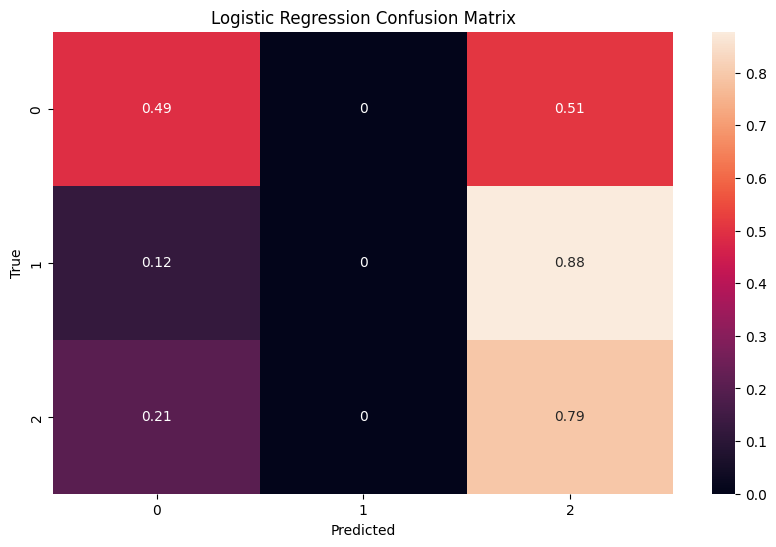

In [43]:

ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")

In [44]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1168
           1       0.00      0.00      0.00       712
           2       0.42      0.79      0.55      1097

    accuracy                           0.49      2977
   macro avg       0.36      0.43      0.37      2977
weighted avg       0.41      0.49      0.42      2977



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Modeling USING SVM

In [ ]:
# train a quick SVM
from sklearn.svm import SVC

svc_model = SVC(gamma='auto')
svc_model.fit(train_image_data, train_label)

SVC(gamma='auto')

In [ ]:
joblib.dump(svc_model, f"{DATA_DIR}/outputs/SVC-Combined-tsne.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/SVC-Combined-tsne.pkl']

In [46]:
# load the specified model for analysis
svc_model = joblib.load(f"{DATA_DIR}/outputs/SVC-Combined-tsne.pkl")

In [47]:
y_pred = svc_model.predict(test_image_data)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'SVC Confusion Matrix')

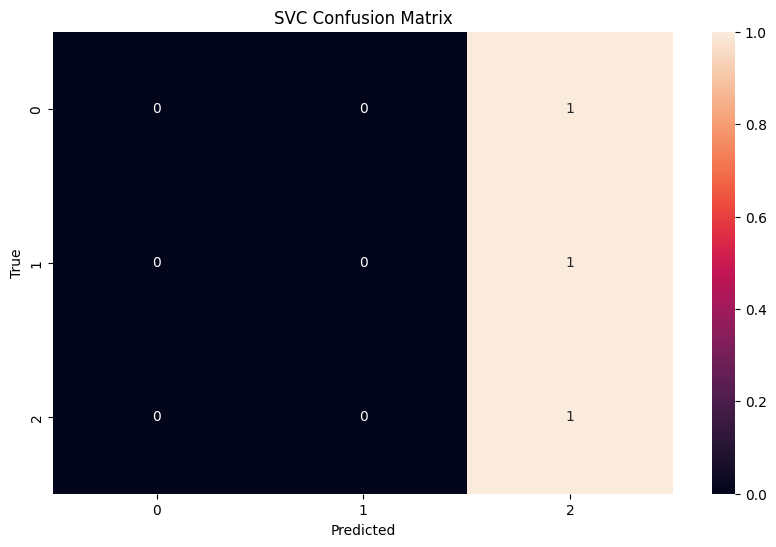

In [48]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVC Confusion Matrix")

In [17]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1168
           1       0.00      0.00      0.00       712
           2       0.37      1.00      0.54      1097

    accuracy                           0.37      2977
   macro avg       0.12      0.33      0.18      2977
weighted avg       0.14      0.37      0.20      2977



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Modeling Using Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(n_estimators=300, 
                                       learning_rate=0.1,
                                      max_depth=3).fit(train_image_data, 
                                                       train_label)


In [ ]:
gbc_model.score(test_image_data, test_label)

0.49344978165938863

In [ ]:
joblib.dump(gbc_model, f"{DATA_DIR}/outputs/GBC-Combined-tsne.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/GBC-Combined-tsne.pkl']

In [67]:
# load the specified model for analysis
gbc_model = joblib.load(f"{DATA_DIR}/outputs/GBC-Combined.pkl")

In [68]:
y_pred = gbc_model.predict(test_image_data)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'GBC Confusion Matrix')

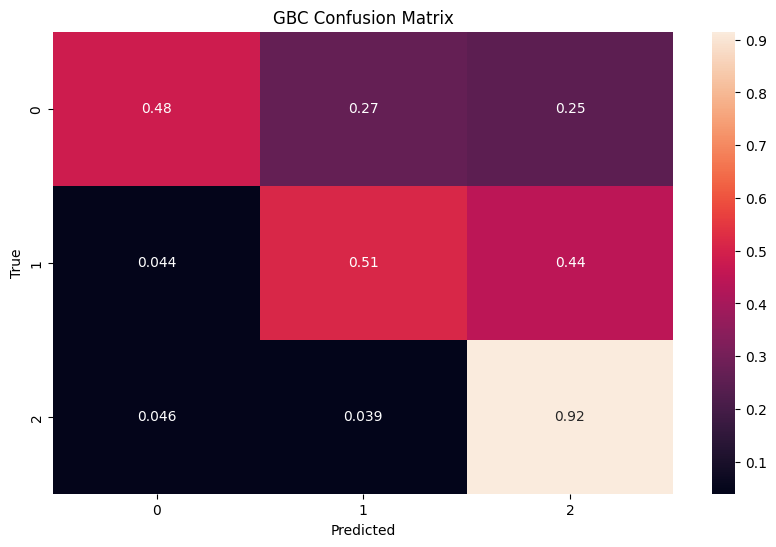

In [69]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GBC Confusion Matrix")

In [70]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.48      0.62      1168
           1       0.51      0.51      0.51       712
           2       0.62      0.92      0.74      1097

    accuracy                           0.65      2977
   macro avg       0.67      0.64      0.62      2977
weighted avg       0.69      0.65      0.64      2977



In [ ]:
# performing AUTOML
# Trying AutoML to determine golden features
# also because I am lazy to try all modeling techniques...
from supervised.automl import AutoML


automl = AutoML(
    mode="Perform", 
    explain_level=1, 
    golden_features=True,
    total_time_limit=30000,
    ml_task="multiclass_classification",
    eval_metric='accuracy',
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 4,
        "shuffle": False,
        "stratify": True,
})

# upsample training 
automl.fit(train_image_data, train_label)

# save the autoML for future usage
# joblib.dump(automl, f"{DATA_DIR}/outputs/CLRS-HIST-autoMLModel.pkl")

# print the nice report :)
# automl.report()

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is multiclass_classification with evaluation metric accuracy
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM accuracy 0.743469 trained in 108.97 seconds (1-sample predict time 0.0527 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

2_Default_Xgboost accuracy 0.739124 trained in 43.26 seconds (1-sample predict time 0.0544 seconds)
3_Default_CatBoost accuracy 0.738518 trained in 25.93 seconds (1-sample predict time 0.0623 seconds)
4_Default_NeuralNetwork accuracy 0.722601 trained in 35.07 seconds (1-sample predict time 0.073 seconds)
5_Default_RandomForest accuracy 0.674499 trained in 28.5 seconds (1-sample predict time 0.1011 seconds)
* Step not_so_random will try to check up to 20 models
10_LightGBM accuracy 0.743065 trained in 41.77 seconds (1-sample predict time 0.0523 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

6_Xgboost accuracy 0.742762 trained in 67.06 seconds (1-sample predict time 0.0548 seconds)
14_CatBoost accuracy 0.739629 trained in 22.74 seconds (1-sample predict time 0.0606 seconds)
18_RandomForest accuracy 0.6746 trained in 21.06 seconds (1-sample predict time 0.0886 seconds)
22_NeuralNetwork accuracy 0.724572 trained in 28.05 seconds (1-sample predict time 0.0752 seconds)
11_LightGBM accuracy 0.742913 trained in 37.81 seconds (1-sample predict time 0.0521 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

7_Xgboost accuracy 0.743621 trained in 73.59 seconds (1-sample predict time 0.0537 seconds)
15_CatBoost accuracy 0.740185 trained in 26.78 seconds (1-sample predict time 0.0605 seconds)
19_RandomForest accuracy 0.707089 trained in 43.64 seconds (1-sample predict time 0.0997 seconds)
23_NeuralNetwork accuracy 0.717144 trained in 46.51 seconds (1-sample predict time 0.0736 seconds)
12_LightGBM accuracy 0.742408 trained in 80.31 seconds (1-sample predict time 0.0514 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

8_Xgboost accuracy 0.747006 trained in 23.29 seconds (1-sample predict time 0.0521 seconds)
16_CatBoost accuracy 0.738972 trained in 27.76 seconds (1-sample predict time 0.064 seconds)
20_RandomForest accuracy 0.662372 trained in 21.57 seconds (1-sample predict time 0.0812 seconds)
24_NeuralNetwork accuracy 0.698449 trained in 36.53 seconds (1-sample predict time 0.0743 seconds)
13_LightGBM accuracy 0.744682 trained in 117.96 seconds (1-sample predict time 0.0516 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

9_Xgboost accuracy 0.743318 trained in 22.31 seconds (1-sample predict time 0.0527 seconds)
17_CatBoost accuracy 0.743217 trained in 36.93 seconds (1-sample predict time 0.0627 seconds)
21_RandomForest accuracy 0.702643 trained in 57.08 seconds (1-sample predict time 0.1001 seconds)
25_NeuralNetwork accuracy 0.719115 trained in 27.93 seconds (1-sample predict time 0.074 seconds)
* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: feature_7_diff_feature_32
Add Golden Feature: feature_32_diff_feature_39
Add Golden Feature: feature_32_sum_feature_26
Add Golden Feature: feature_28_diff_feature_32
Add Golden Feature: feature_32_sum_feature_23
Add Golden Feature: feature_32_sum_feature_28
Add Golden Feature: feature_32_sum_feature_24
Add Golden Feature: feature_27_diff_feature_32
Add Golden Feature: feature_30_diff_feature_32
Add Golden Feature: feature_32_sum_feature_29
Created 10 Golden Features in 11.76 seconds.


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

8_Xgboost_GoldenFeatures accuracy 0.745895 trained in 43.66 seconds (1-sample predict time 0.0788 seconds)
13_LightGBM_GoldenFeatures accuracy 0.744177 trained in 130.88 seconds (1-sample predict time 0.081 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

7_Xgboost_GoldenFeatures accuracy 0.739629 trained in 61.01 seconds (1-sample predict time 0.076 seconds)
* Step insert_random_feature will try to check up to 1 model


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

8_Xgboost_RandomFeature accuracy 0.746147 trained in 30.0 seconds (1-sample predict time 0.0596 seconds)
Drop features ['feature_25', 'feature_4', 'feature_3', 'feature_55', 'feature_8', 'feature_42', 'feature_61', 'feature_73', 'feature_68', 'random_feature', 'feature_17', 'feature_10', 'feature_14', 'feature_74', 'feature_11', 'feature_15', 'feature_20', 'feature_51', 'feature_16', 'feature_12', 'feature_80', 'feature_58', 'feature_18', 'feature_53', 'feature_19', 'feature_56', 'feature_67', 'feature_59', 'feature_5', 'feature_40']
* Step features_selection will try to check up to 5 models


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

8_Xgboost_SelectedFeatures accuracy 0.743924 trained in 20.65 seconds (1-sample predict time 0.0446 seconds)
13_LightGBM_SelectedFeatures accuracy 0.739528 trained in 97.2 seconds (1-sample predict time 0.0412 seconds)
17_CatBoost_SelectedFeatures accuracy 0.743621 trained in 25.49 seconds (1-sample predict time 0.0454 seconds)
22_NeuralNetwork_SelectedFeatures accuracy 0.708807 trained in 31.37 seconds (1-sample predict time 0.0599 seconds)
19_RandomForest_SelectedFeatures accuracy 0.70719 trained in 42.02 seconds (1-sample predict time 0.1081 seconds)
* Step hill_climbing_1 will try to check up to 16 models


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

26_Xgboost accuracy 0.746855 trained in 26.21 seconds (1-sample predict time 0.0716 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

27_Xgboost accuracy 0.74736 trained in 26.47 seconds (1-sample predict time 0.0539 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

28_Xgboost_GoldenFeatures accuracy 0.74448 trained in 28.97 seconds (1-sample predict time 0.0779 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

29_Xgboost_GoldenFeatures accuracy 0.746198 trained in 35.46 seconds (1-sample predict time 0.0758 seconds)
30_LightGBM accuracy 0.744682 trained in 118.79 seconds (1-sample predict time 0.0527 seconds)
31_LightGBM_GoldenFeatures accuracy 0.744177 trained in 130.99 seconds (1-sample predict time 0.0751 seconds)
32_CatBoost_SelectedFeatures accuracy 0.741094 trained in 25.4 seconds (1-sample predict time 0.0468 seconds)
33_CatBoost_SelectedFeatures accuracy 0.740235 trained in 22.45 seconds (1-sample predict time 0.0458 seconds)
34_CatBoost accuracy 0.744783 trained in 43.5 seconds (1-sample predict time 0.0607 seconds)
35_CatBoost accuracy 0.740084 trained in 29.24 seconds (1-sample predict time 0.0632 seconds)
36_NeuralNetwork accuracy 0.719519 trained in 28.28 seconds (1-sample predict time 0.073 seconds)
37_NeuralNetwork accuracy 0.719418 trained in 38.9 seconds (1-sample predict time 0.0745 seconds)
38_NeuralNetwork accuracy 0.721389 trained in 26.09 seconds (1-sample predict time 

/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

42_Xgboost accuracy 0.747562 trained in 29.03 seconds (1-sample predict time 0.0544 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

43_Xgboost accuracy 0.746754 trained in 26.64 seconds (1-sample predict time 0.0531 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

44_Xgboost accuracy 0.748269 trained in 30.51 seconds (1-sample predict time 0.054 seconds)


/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
/usr/local/lib/python3.9/dist-packages/xgboost/training.py:39: UserWarning: `fe

45_Xgboost accuracy 0.748421 trained in 24.96 seconds (1-sample predict time 0.0529 seconds)
46_CatBoost accuracy 0.742812 trained in 37.44 seconds (1-sample predict time 0.0606 seconds)
47_CatBoost accuracy 0.743469 trained in 40.35 seconds (1-sample predict time 0.0615 seconds)
48_LightGBM accuracy 0.744884 trained in 118.44 seconds (1-sample predict time 0.0514 seconds)
49_LightGBM accuracy 0.744884 trained in 119.21 seconds (1-sample predict time 0.0509 seconds)
50_CatBoost_SelectedFeatures accuracy 0.741701 trained in 22.93 seconds (1-sample predict time 0.046 seconds)
51_CatBoost_SelectedFeatures accuracy 0.743166 trained in 26.23 seconds (1-sample predict time 0.0455 seconds)
52_NeuralNetwork accuracy 0.719923 trained in 28.0 seconds (1-sample predict time 0.0731 seconds)
53_NeuralNetwork accuracy 0.703906 trained in 27.35 seconds (1-sample predict time 0.0731 seconds)
54_NeuralNetwork accuracy 0.711586 trained in 29.41 seconds (1-sample predict time 0.0759 seconds)
55_NeuralNet

AutoML(eval_metric='accuracy', explain_level=1, golden_features=True,
       ml_task='multiclass_classification', mode='Perform',
       total_time_limit=30000,
       validation_strategy={'k_folds': 4, 'shuffle': False, 'stratify': True,
                            'validation_type': 'kfold'})

In [ ]:
# save the autoML for future usage
pickle.dump(automl, open(f"{DATA_DIR}/outputs/Combined-autoMLModel.pkl", "wb"))

In [71]:
automl = pickle.load(open(f"{DATA_DIR}/outputs/Combined-autoMLModel.pkl", "rb"))

In [72]:
#automl.report()

In [73]:
# print the report
y_pred = automl.predict(test_image_data)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'AutoML Confusion Matrix')

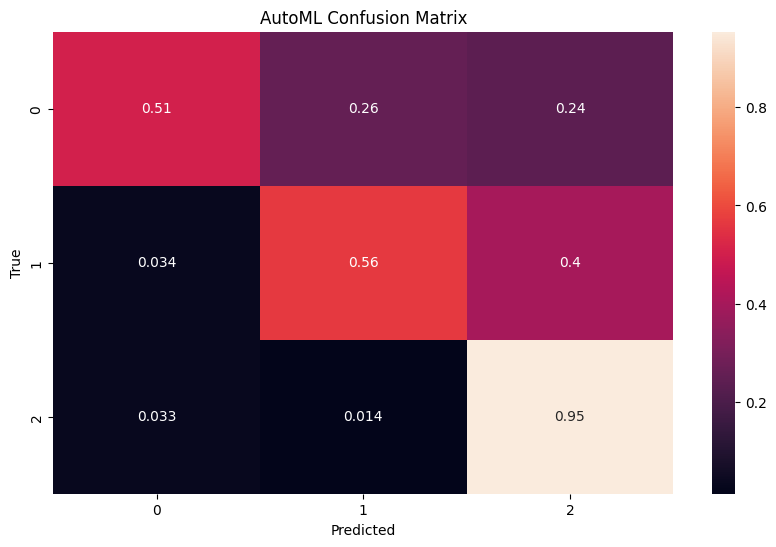

In [74]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AutoML Confusion Matrix")

In [75]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.51      0.65      1168
           1       0.56      0.56      0.56       712
           2       0.65      0.95      0.77      1097

    accuracy                           0.68      2977
   macro avg       0.71      0.67      0.66      2977
weighted avg       0.73      0.68      0.67      2977



In [ ]:
# quick plot / analysis on the data analysis part
data = {
    "Logistic Regression": 0.37,
    "SVC": 0.37,
    "GBC": 0.65,
    "autoML": 0.66
}

accuracy = pd.DataFrame().from_dict(data, orient='index')
accuracy

,0
Logistic Regression,0.37
SVC,0.37
GBC,0.65
autoML,0.66


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVC'),
  Text(2, 0, 'GBC'),
  Text(3, 0, 'autoML')])

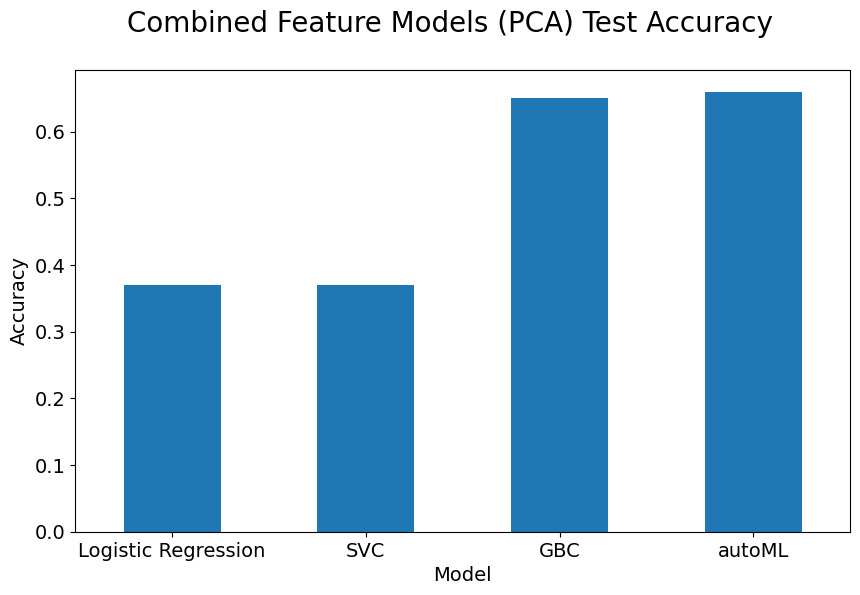

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
accuracy[0].plot(kind='bar')
# set figure title

fig.suptitle('Combined Feature Models (PCA) Test Accuracy', fontsize=20)
# set x and y labels
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation = 0, fontsize=14)